In [1]:
# Step-2:
#### 1. Image Contrast
#### 2. Data Split (Train(80), Validation(20))
#### 3. Transfer learning

In [13]:
pip install --upgrade pip --user

  Using cached pip-23.1.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install tensorflow --user

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import tensorflow as tf
import keras
from imageContrast import img_cont
from skimage import exposure
from pylab import *
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from imageCropping import crop_img
import tensorflow_addons as tfa

C:\Users\v4run\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
trainingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/TrainingDataset'

In [19]:
def imgContrastPreprocess(images, labels):
    equalized_images = tf.map_fn(lambda img: tf.py_function(img_cont, [img], Tout=tf.float32), images, fn_output_signature=tf.float32)
    return equalized_images, labels

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    subset='training'
)

Found 9625 files belonging to 2 classes.
Using 7700 files for training.


In [5]:
val_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    subset='validation'
)

Found 9625 files belonging to 2 classes.
Using 1925 files for validation.


In [6]:
trainDataset = train_data.map(imgContrastPreprocess).repeat()

In [7]:
validDataset = val_data.map(imgContrastPreprocess)

In [8]:
# Model Structure
# parallel branches and dilated convolution using the Keras Functional API

In [8]:
input_img = Input(shape=(128,128,3))

# Layer 1 and Parallel branches1
conv1 = Conv2D(32,(3,3), activation = 'relu', padding='same')(input_img)
l1branch1 = Conv2D(32,(5,5), activation = 'relu', padding='same')(input_img)

# Concatenate
l1concatenateBranch = concatenate([conv1,l1branch1], axis=-1) #fix this to 3 or -1

#conv layer
maxPool1 = MaxPooling2D(2,2)(l1concatenateBranch)

# layer 2 and Parallel branches2
conv2 = Conv2D(64,(3,3), activation = 'relu', padding='same')(maxPool1)
l2branch1 = Conv2D(64,(5,5), activation = 'relu', padding='same')(maxPool1)

# Concatenate
l2concatenateBranch = concatenate([conv2,l2branch1], axis=-1) #fix this to 3 or -1

#conv layer
maxPool2 = MaxPooling2D(2,2)(l2concatenateBranch)


# layer 3 and Parallel branches2
conv3 = Conv2D(128,(3,3), activation = 'relu', padding='same')(maxPool2)
l3branch1 = Conv2D(128,(5,5), activation = 'relu', padding='same')(maxPool2)
# Concatenate
l3concatenateBranch = concatenate([conv3,l3branch1], axis=-1) #fix this to 3 or -1

#conv layer
maxPool3 = MaxPooling2D(2,2)(l3concatenateBranch)

# Dilated convulation3
l3dilatedConv = Conv2D(128,(3,3), activation = 'relu', padding='same', dilation_rate=2)(l3concatenateBranch)
l3dilatedConv = MaxPooling2D((2,2),padding = 'same')(l3dilatedConv)

# Flatten and fully connected layers
flat = Flatten()(l3dilatedConv)
dense1 = Dense(128,activation='relu')(flat)
dense2 = Dense(1,activation='sigmoid')(dense1)

model = Model(inputs=input_img, outputs=dense2)
f1Score = tfa.metrics.F1Score(num_classes=1,average='macro',threshold=0.5)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1Score])
earlyStopping = EarlyStopping(monitor='val_f1_score', patience=10, verbose=1, mode='max')
checkPoint = ModelCheckpoint(
    'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/parallelBranch1.h5',
    monitor = 'val_f1_score',
    verbose = 1,
    save_best_only=True,
    mode='max'
)
history = model.fit(
    trainDataset,
    steps_per_epoch=floor(7700//32),
    epochs=100,
    validation_data=validDataset,
    validation_steps=floor(1925//32),
    callbacks=[earlyStopping,checkPoint]
)

loss, accuracy = model.evaluate(validDataset,steps=floor(1925//32))

Epoch 1/100
240/240 [==============================] - ETA: 0s - loss: 0.6322 - f1_score: 0.6558
Epoch 1: val_f1_score improved from -inf to 0.78448, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\parallelBranch1.h5
240/240 [==============================] - 592s 2s/step - loss: 0.6322 - f1_score: 0.6558 - val_loss: 0.4906 - val_f1_score: 0.7845
Epoch 2/100
240/240 [==============================] - ETA: 0s - loss: 0.4059 - f1_score: 0.8215
Epoch 2: val_f1_score improved from 0.78448 to 0.83803, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\parallelBranch1.h5
240/240 [==============================] - 578s 2s/step - loss: 0.4059 - f1_score: 0.8215 - val_loss: 0.3812 - val_f1_score: 0.8380
Epoch 3/100
240/240 [==============================] - ETA: 0s - loss: 0.3494 - f1_score: 0.8512
Epoch 3: val_f1_score improved from 0.83803 to 0.87506, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\paral

In [6]:
history

best_epochLocation = history.history['val_f1_score'].index(max(history.history['val_f1_score']))
best_epochLocation
best_history = {key: values[:best_epochLocation + 1] for key, values in history.history.items()}
best_history
history
best_epochLocation = history.history['val_f1_score'].index(max(history.history['val_f1_score']))
best_epochLocation
best_history = {key: values[:best_epochLocation + 1] for key, values in history.history.items()}
best_history
history


In [4]:
best_epochLocation = history.history['val_f1_score'].index(max(history.history['val_f1_score']))
best_epochLocation

NameError: name 'history' is not defined

In [5]:
best_history = {key: values[:best_epochLocation + 1] for key, values in history.history.items()}
best_history

NameError: name 'history' is not defined

In [15]:
model.save('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel.h5')

In [11]:
savedModel = tf.keras.models.load_model('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/parallelBranch1.h5')

In [12]:
acc = best_history['f1_score']
loss = best_history['loss']
val_acc = best_history['val_f1_score']
val_loss = best_history['val_loss']

In [13]:
epoch = range(1, len(acc)+1)

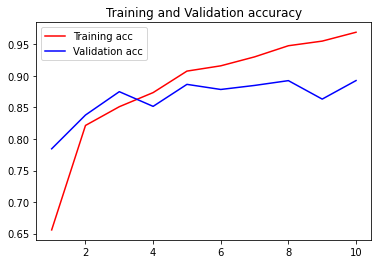

In [14]:
plt.plot(epoch, acc, 'r', label = 'Training acc')
plt.plot(epoch, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

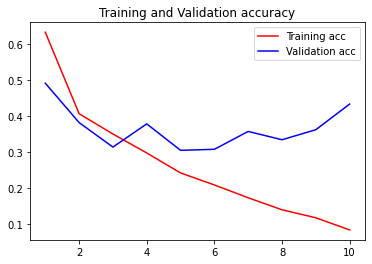

In [15]:
plt.plot(epoch, loss, 'r', label = 'Training acc')
plt.plot(epoch, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

In [16]:
# Test Data

In [10]:
testingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2'

In [11]:
test_data = tf.keras.utils.image_dataset_from_directory(
    testingDataPath,
    seed=21,
    image_size=(128, 128),
    batch_size=32
)

Found 3553 files belonging to 2 classes.


In [12]:
#crop Data

In [13]:
def imgCropPreprocess(images,labels):
    cropped_images = tf.map_fn(lambda img: tf.py_function(crop_img, [img], Tout=tf.float32), images)
    return cropped_images,labels

In [14]:
testCropped_data = test_data.map(imgCropPreprocess)

In [15]:
a = testCropped_data.as_numpy_iterator()

In [16]:
img, label = a.next()

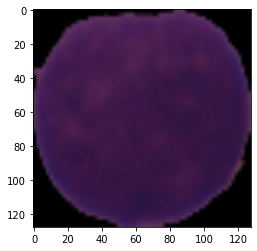

In [17]:
imshow(img[0])

In [20]:
testCont_data = testCropped_data.map(imgContrastPreprocess)

In [21]:
saved_model = tf.keras.models.load_model('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/parallelBranch1.h5')

In [22]:
# prediction

In [23]:
y_predict = saved_model.predict(testCont_data)

112/112 [==============================] - 79s 700ms/step


In [24]:
y_predict_binary = (y_predict>0.5).astype(int)

In [25]:
y_pred = np.round(y_predict).flatten()

In [26]:
y_predict_binary

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [27]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [28]:
y_true = np.concatenate([y for x, y in testCont_data], axis=0)

In [29]:
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)
f1Score = f1_score(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1_score: {f1Score:.4f}')

Precision: 0.7262
Recall: 0.0993
f1_score: 0.1747


In [30]:
confusionMatrix = confusion_matrix(y_true, y_predict_binary)
print(confusionMatrix)

[[1004   92]
 [2213  244]]


In [37]:
layer_names = [layer.name for layer in saved_model.layers if 'conv' in layer.name]
visualize_model = Model(inputs=saved_model.inputs, outputs=[saved_model.get_layer(name).output for name in layer_names])

In [38]:
a = testCont_data.as_numpy_iterator()

In [39]:
img1, label1 = a.next()

In [40]:
img10,label10 = img1[0],label1[0]

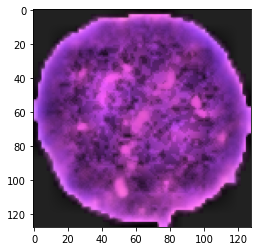

In [41]:
imshow(img10)

In [42]:
label10

1

In [43]:
img10 = np.expand_dims(img10,axis=0)

In [44]:
saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  2432        ['input_1[0][0]']                
                                )                                                             

In [45]:
(saved_model.predict(img10)>0.5).astype(int)

1/1 [==============================] - 0s 135ms/step


array([[0]])

In [46]:
activations = visualize_model(img10)

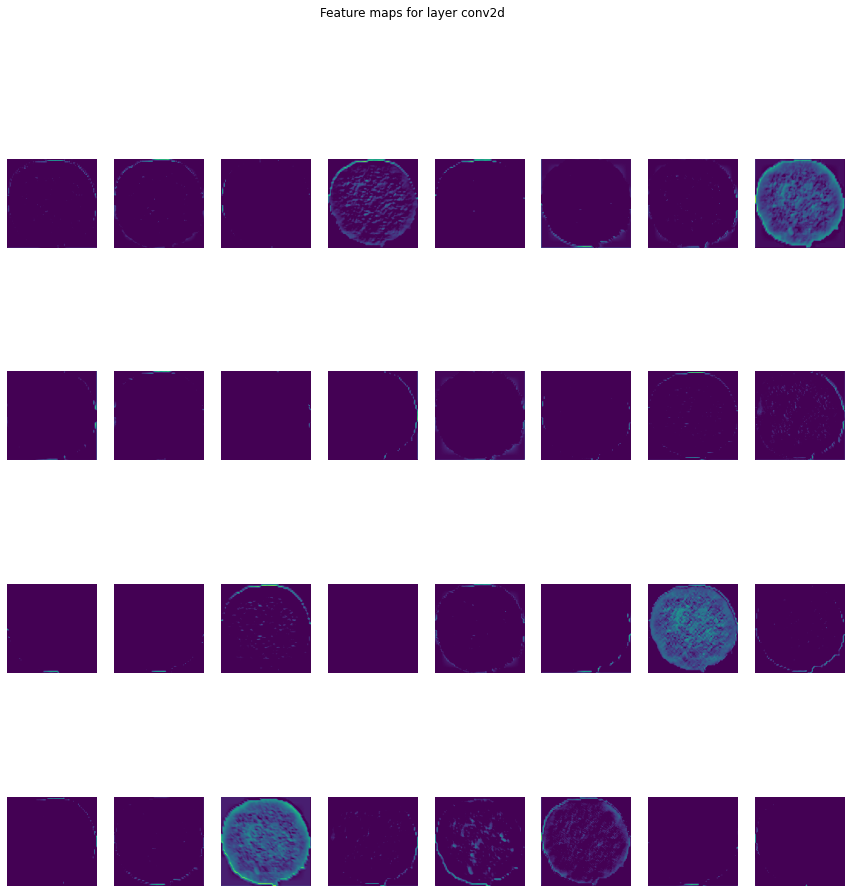

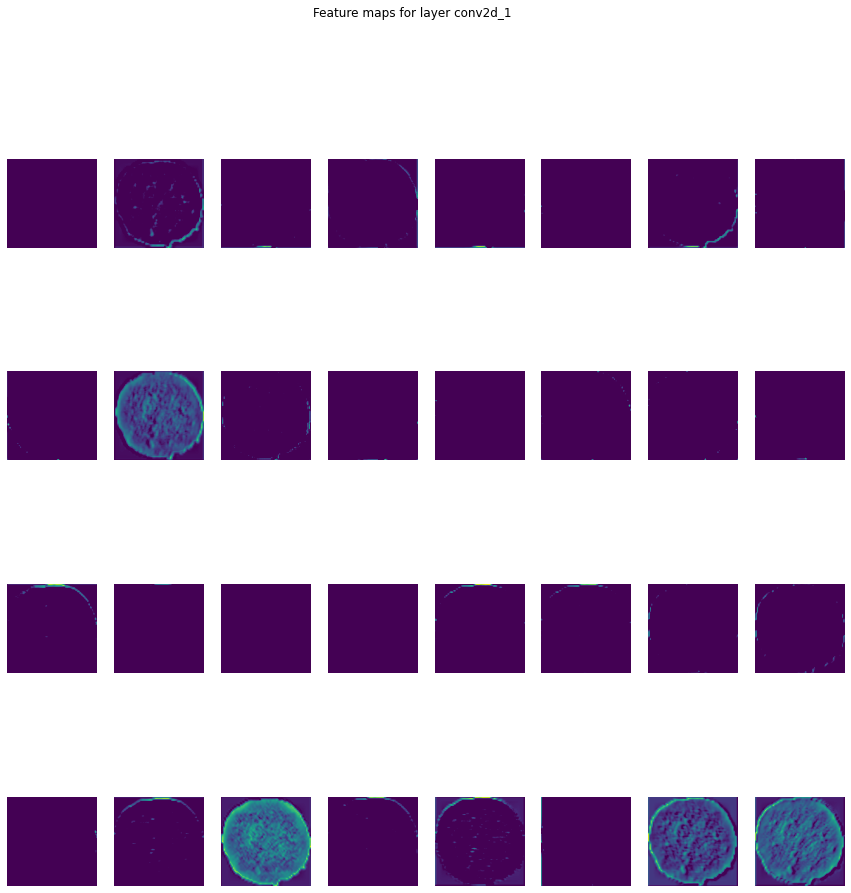

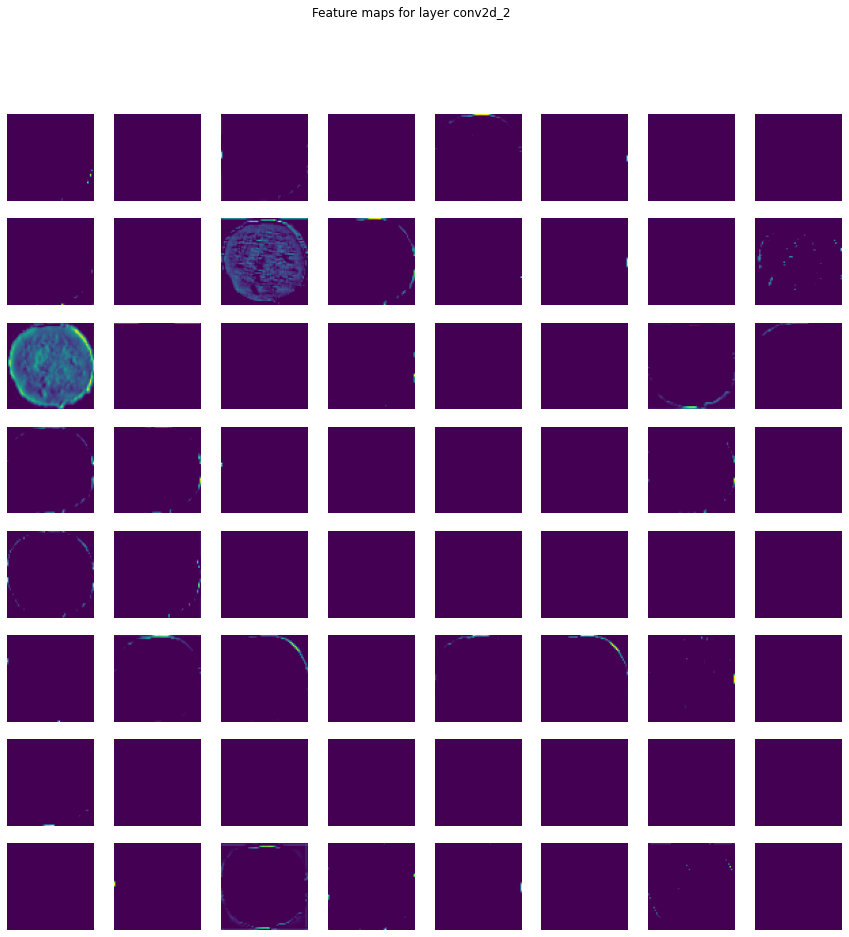

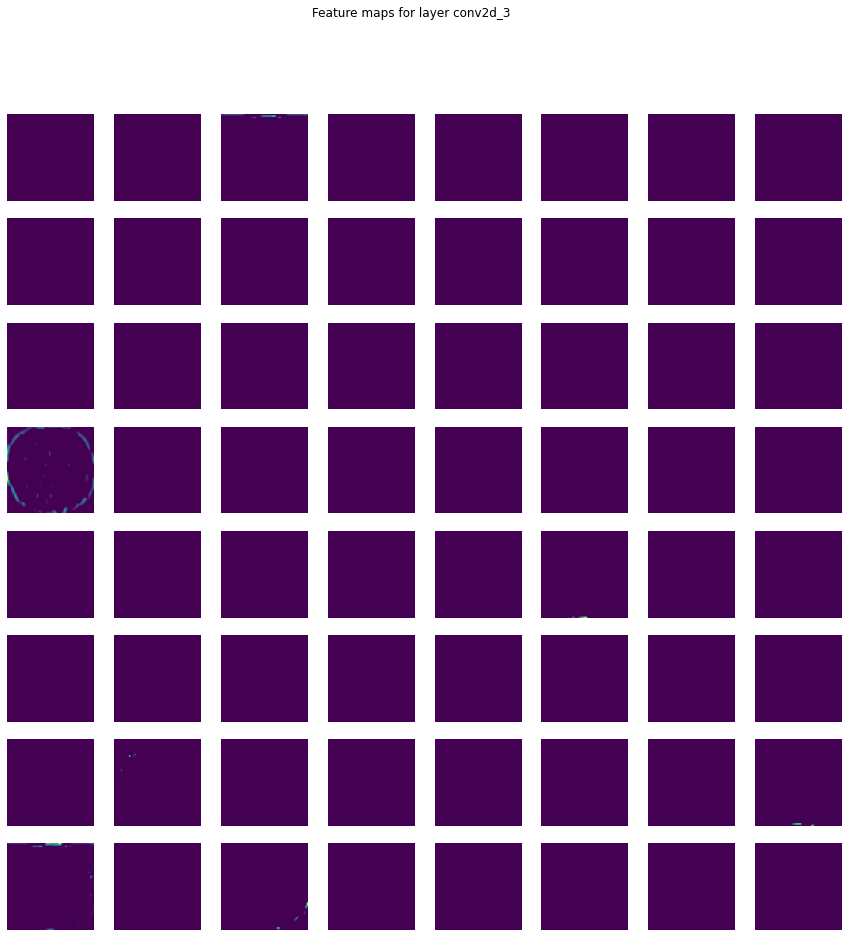

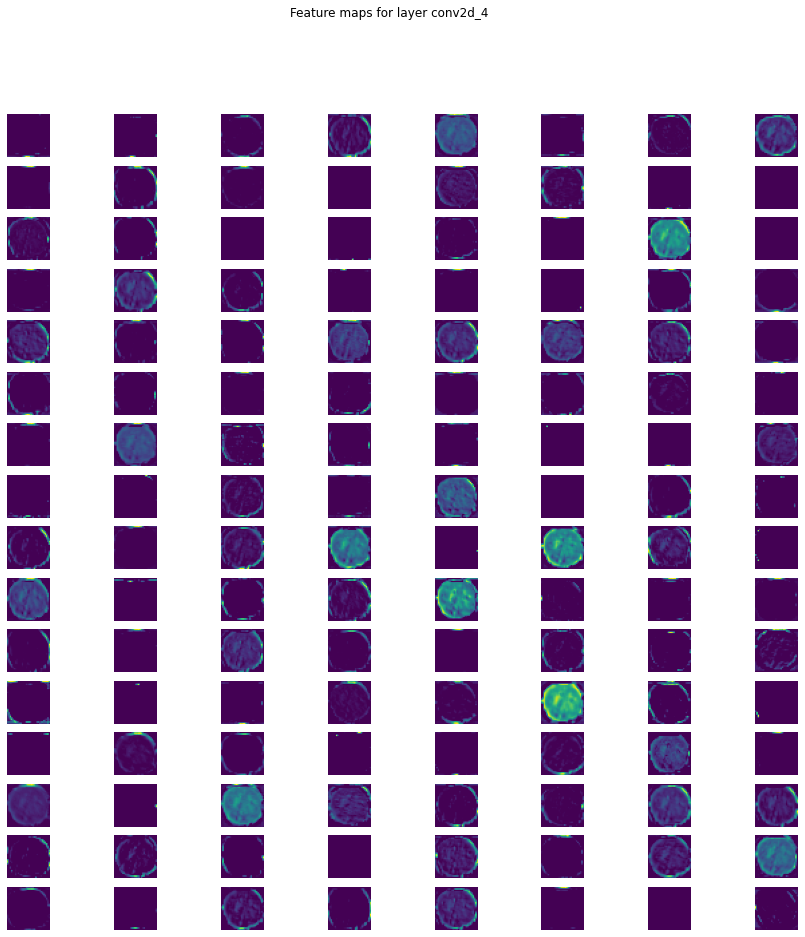

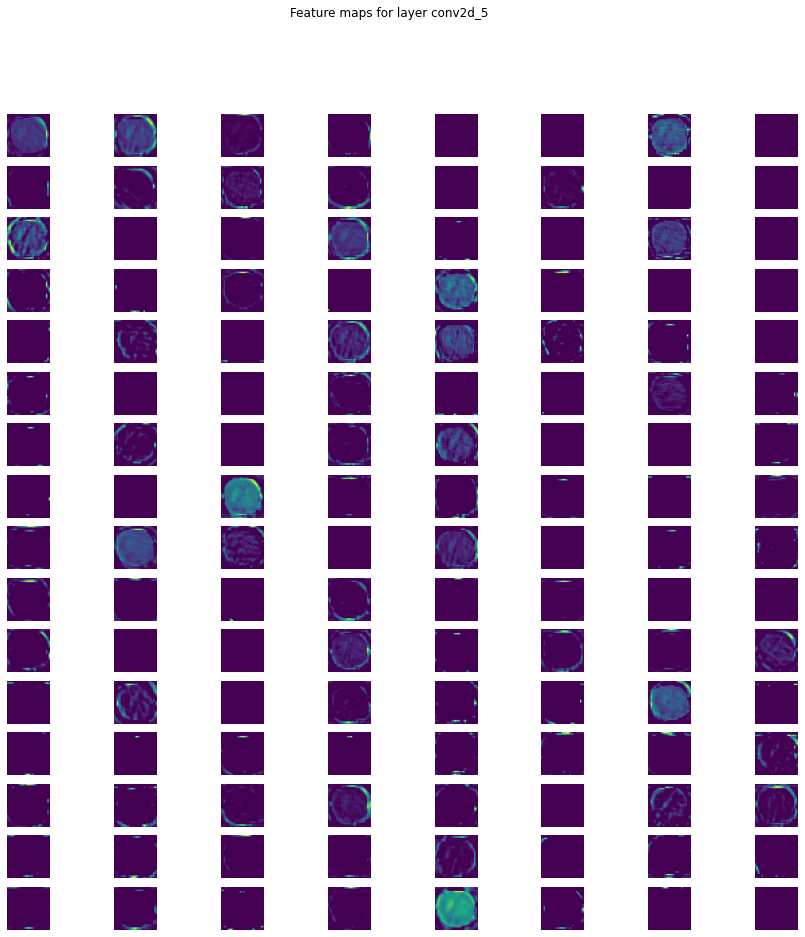

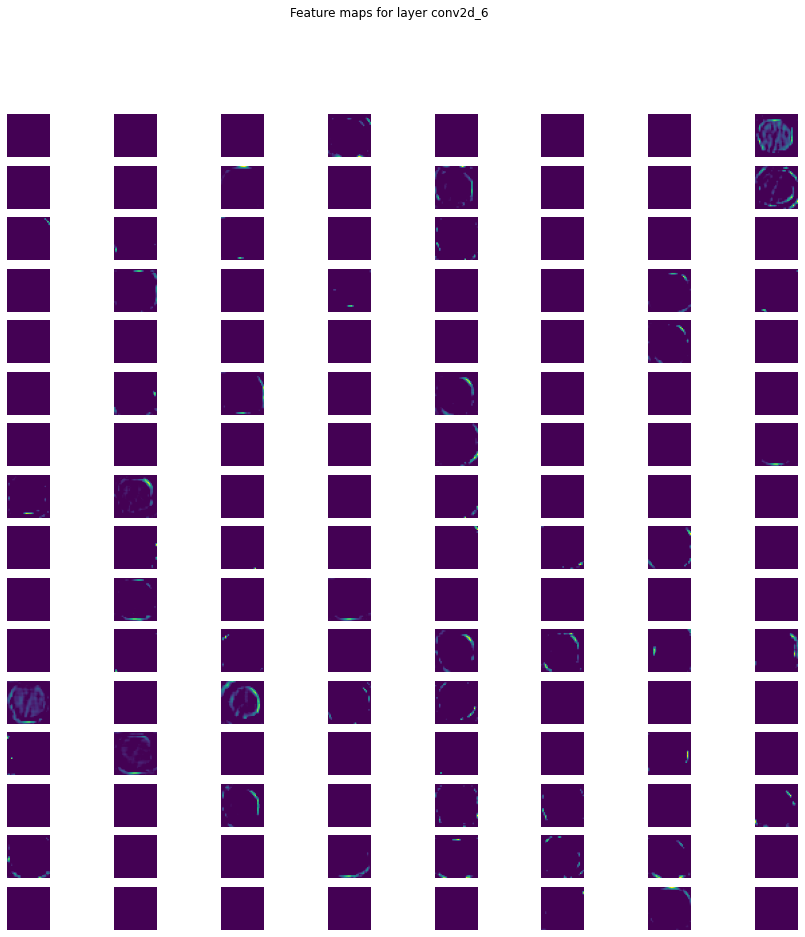

In [47]:
def display_feature_maps(activations, layer_names):
    for i, activation in enumerate(activations):
        layer_name = layer_names[i]
        num_filters = activation.shape[-1]

        # Calculate the number of rows and columns for the grid
        no_cols = 8
        grid_rows = num_filters // no_cols

        fig, axes = plt.subplots(grid_rows, no_cols, figsize=(15, 15))
        fig.suptitle(f"Feature maps for layer {layer_name}")

        for j in range(num_filters):
            ax = axes[j // no_cols, j % no_cols]
            ax.imshow(activation[0, :, :, j], cmap='viridis')
            ax.axis('off')

        plt.show()

# Call the function with the activations and layer names
display_feature_maps(activations, layer_names)